Python script to import data for churn analysis for mobile fitness app. 
Data cleaning and feature engineering was completed in RStudio, by directly interfacing with a PostgreSQL database hosted on AWS. 

In [11]:
# import
import pandas as pd
import numpy as np
import os

# import scikitlearn 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, classification_report
from sklearn import tree
from sklearn import metrics
from sklearn.externals.six import StringIO  

# plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pydotplus


# for feature importance
import eli5
from eli5.sklearn import PermutationImportance
from eli5.formatters.as_dataframe import format_as_dataframes

# for cross-validation
from sklearn.model_selection import GridSearchCV

# for confusion matrix
from sklearn.metrics import confusion_matrix

# for ROC graph
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Model 1: Examining churn as defined by users that logged in only one time or less following the first week with the app

In [3]:
# Import the data
model_df = pd.read_csv('modeldf_updatedmultiChurn.csv') # variables are not scaled
#model_wk1active = pd.read_csv('wk1activeONLY.csv') # Only including individuals that had activity during wk1

Model used was a random forest classifier

In [4]:
# Look at the data
model_df.head()

,Unnamed: 0,userID,dayswithApp,Wk1ActiveDays,NumfirstWeeklogins,NumfirstWeekRuns,NumfirstWeekSess,NumfirstWeekEnroll,NumfirstWeekSM,NumfirstWeekAL,planType,userType,churn,churnAL,userTypeNumeric,churnlevels
0,1,00000000-5704-6615-a2ab-44376358dc8e,52,7,70,0,4,1,15,15,annual,premium,0,0,1,0
1,2,00000000-5777-0b85-44c3-2a2c22b8b0e7,46,1,10,0,0,0,0,0,none,free,0,1,0,1
2,3,00000000-579f-f5c5-aa50-e8f732c1ba9a,48,3,11,0,0,0,0,0,monthly,premium,0,1,1,1
3,4,00000000-584d-a4f0-bdee-d4102b989ce5,44,3,6,0,0,0,51,51,none,free,0,1,0,1
4,5,00000000-584e-1f39-bdee-d4102b989d01,52,7,16,0,0,0,0,0,none,free,0,0,0,0


In [41]:
# RANDOM FOREST 
# instantiate the model

# using model_df as the input

# split dataset in features and target variable
# can include NON-normalized inputs because with algorithms based on recursive partitioning, such as decision trees, and regression trees does not require inputs (features) to be normalized, since it is invariant to monotonic transformations of the features (just think about how the splits are done at each node).
feature_cols = ['NumfirstWeeklogins','Wk1ActiveDays','NumfirstWeekRuns','NumfirstWeekSess','NumfirstWeekEnroll', 'NumfirstWeekSM', 'userTypeNumeric']
x = model_df[feature_cols] # Features
y = model_df["churn"] # Target variable

# split X and y into training and testing sets
# adding 'stratify=y' means the testing and training data contain same proportion of 0,1
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0, stratify=y)


# base RF classifier
rfc = RandomForestClassifier(random_state=0)

In [6]:
## setting the hyperparameters to search using 5-fold cross validation grid search
param_grid = { 
    'n_estimators': [1,4,5,8,16,32,50,75,80,100,120,150,180,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,12,15,18,20],
    'criterion' :['gini', 'entropy']
}

In [7]:
# Run grid search for 5-fold cross validation on the training data
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 5, 8, 16, 32, 50, 75, 80, 100, 120, 150, 180, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 10, 12, 15, 18, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
# print the best parameters based on the grid search to plug into the model 
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 32}

In [42]:
# Define model using the best paramaters from the grid search and balanced weight class
# class_weight="balanced" can be added to this as well
clf = RandomForestClassifier(n_estimators = 32, class_weight="balanced", max_depth=7, criterion = "entropy", max_features="auto",random_state=0)

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [43]:
# Print out metrics of model fit
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

print(classification_report(y_test,y_pred))

Accuracy: 0.7945326278659612
Precision: 0.6920415224913494
Recall: 0.8791208791208791
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       679
           1       0.69      0.88      0.77       455

   micro avg       0.79      0.79      0.79      1134
   macro avg       0.80      0.81      0.79      1134
weighted avg       0.82      0.79      0.80      1134



In [44]:
# Visualise classical Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[501, 178],
       [ 55, 400]])

In [45]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Absolute Mean error:', round(np.mean(errors), 2), ' Percent.')

Absolute Mean error: 0.21  Percent.


In [46]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(y_test, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_importances = pd.DataFrame({'feature': list(feature_cols), 'importance':importances})

feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

              feature  importance
1       Wk1ActiveDays    0.532751
0  NumfirstWeeklogins    0.392686
5      NumfirstWeekSM    0.023394
3    NumfirstWeekSess    0.022816
4  NumfirstWeekEnroll    0.016845
6     userTypeNumeric    0.008064
2    NumfirstWeekRuns    0.003444


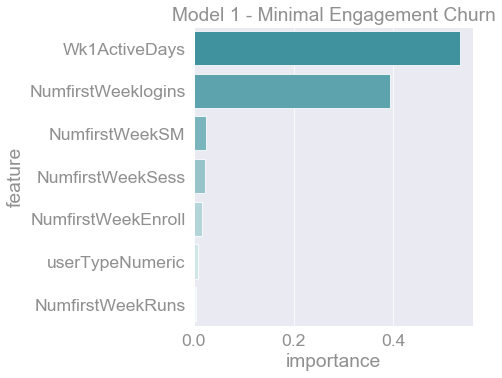

In [48]:
# Plot feature importance for model #1
sns.set_context('paper', font_scale=2)

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'


sns.color_palette("Blues")
plt.figure(figsize=(5,5.5))
ax = sns.barplot(x = 'importance', y='feature', data=feature_importances, palette=sns.light_palette((210, 90, 60), n_colors=7, input="husl", reverse=True))


plt.title('Model 1 - Minimal Engagement Churn');
#plt.savefig('Model1_FeatureImportance2.pdf', bbox_inches='tight')
plt.show()

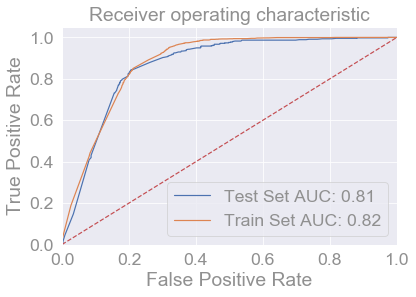

In [49]:
# Create ROC curve for Model 1
rf_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Test Set AUC: %0.2f' % rf_roc_auc)

# add the ROC curve for the test set
rf_roc_auctrain = roc_auc_score(y_train, clf.predict(x_train))
fpr2, tpr2, thresholds = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
#plt.figure()
plt.plot(fpr2, tpr2, label='Train Set AUC: %0.2f' % rf_roc_auctrain)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Model1_ROCcurve.pdf', bbox_inches='tight')
plt.show()

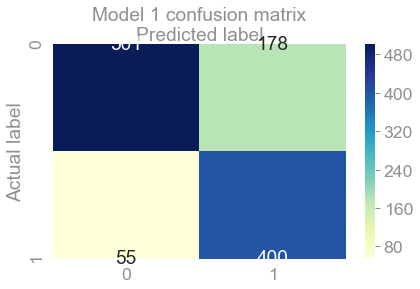

In [18]:
# PRINT OUT A PRETTY CONFUSION MATRIX
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Model 1 confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig("Model1_confusionmatrix.pdf", bbox_inches='tight')
plt.show()

Model 2: Examining churn as defined by users that did not actively engage in the app following the first week

Active engagement includes: social media interactions, GPS-logged runs, enrollment in tracks, completion of sessions

In [22]:
# RANDOM FOREST 
# instantiate the model first using default 
# model_wk1active is the dset NO

# split dataset in features and target variable
# can include NON-normalized inputs because with algorithms based on recursive partitioning, such as decision trees, and regression trees does not require inputs (features) to be normalized, since it is invariant to monotonic transformations of the features (just think about how the splits are done at each node).
feature_cols2 = ['NumfirstWeeklogins','Wk1ActiveDays','NumfirstWeekRuns','NumfirstWeekSess','NumfirstWeekEnroll', 'NumfirstWeekSM', 'userTypeNumeric']
x = model_df[feature_cols] # Features
y = model_df["churnAL"] # Target variable

# split X and y into training and testing sets
# adding 'stratify=y' means the testing and training data contain same proportion of 0,1
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0, stratify=y)

# default parameters first
rfc = RandomForestClassifier(random_state=0)

In [23]:
# Create grid for parameter search
param_grid = { 
    'n_estimators': [1,4,5,8,16,32,50,75,80,100,120,150,180,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,12,15,18,20],
    'criterion' :['gini', 'entropy']
}

In [24]:
model_df.head()

,Unnamed: 0,userID,dayswithApp,Wk1ActiveDays,NumfirstWeeklogins,NumfirstWeekRuns,NumfirstWeekSess,NumfirstWeekEnroll,NumfirstWeekSM,NumfirstWeekAL,planType,userType,churn,churnAL,userTypeNumeric,churnlevels
0,1,00000000-5704-6615-a2ab-44376358dc8e,52,7,70,0,4,1,15,15,annual,premium,0,0,1,0
1,2,00000000-5777-0b85-44c3-2a2c22b8b0e7,46,1,10,0,0,0,0,0,none,free,0,1,0,1
2,3,00000000-579f-f5c5-aa50-e8f732c1ba9a,48,3,11,0,0,0,0,0,monthly,premium,0,1,1,1
3,4,00000000-584d-a4f0-bdee-d4102b989ce5,44,3,6,0,0,0,51,51,none,free,0,1,0,1
4,5,00000000-584e-1f39-bdee-d4102b989d01,52,7,16,0,0,0,0,0,none,free,0,0,0,0


In [25]:
# print the best parameters based on the grid search to plug into the model using 5-fold CV grid search
CV_rfc2 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc2.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 5, 8, 16, 32, 50, 75, 80, 100, 120, 150, 180, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 10, 12, 15, 18, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
# print the best parameters based on the grid search to plug into the model 
CV_rfc2.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 4}

In [27]:
# class_weight="balanced" can be added to this as well
clf2 = RandomForestClassifier(n_estimators = 4, class_weight="balanced", max_depth=4, criterion="entropy", max_features="auto", random_state=0)

# Train Decision Tree Classifer
clf2 = clf2.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf2.predict(x_test)

In [28]:
# Print out metrics of model fit
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

print(classification_report(y_test,y_pred))

Accuracy: 0.8447971781305115
Precision: 0.9154228855721394
Recall: 0.9099901088031652
              precision    recall  f1-score   support

           0       0.29      0.31      0.30       123
           1       0.92      0.91      0.91      1011

   micro avg       0.84      0.84      0.84      1134
   macro avg       0.60      0.61      0.61      1134
weighted avg       0.85      0.84      0.85      1134



In [29]:
# Get numerical feature importances
importances = list(clf2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(y_test, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_importances2 = pd.DataFrame({'feature': list(feature_cols), 'importance':importances})

feature_importances2 = feature_importances2.sort_values(by='importance', ascending=False)
print(feature_importances2)

              feature  importance
3    NumfirstWeekSess    0.422545
5      NumfirstWeekSM    0.243859
0  NumfirstWeeklogins    0.113492
1       Wk1ActiveDays    0.095322
4  NumfirstWeekEnroll    0.086381
6     userTypeNumeric    0.026513
2    NumfirstWeekRuns    0.011887


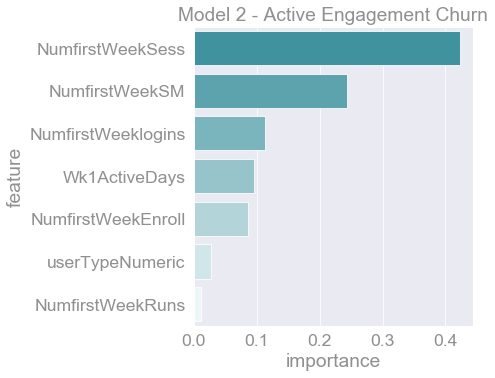

In [31]:
# Create graph of feature importance for model 2
sns.set_context('paper', font_scale=2)

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'


sns.color_palette("Blues")
plt.figure(figsize=(5,5.5));
ax = sns.barplot(x = 'importance', y='feature', data=feature_importances2, palette=sns.light_palette((210, 90, 60), n_colors=7, input="husl", reverse=True))


plt.title('Model 2 - Active Engagement Churn');
#plt.savefig('Model2_FeatureImportance.pdf', bbox_inches='tight')
plt.show()

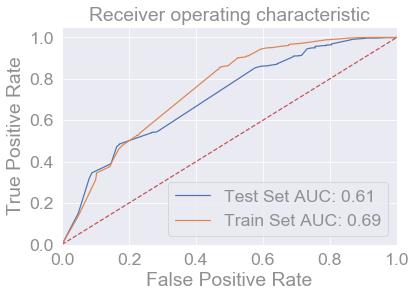

In [34]:
# Creating the ROC curve for model 2
rf_roc_auc = roc_auc_score(y_test, clf2.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf2.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Test Set AUC: %0.2f' % rf_roc_auc)
#plt.plot(fpr,tpr,label="Random Forest, auc="+str(rf_roc_auc))

# add the ROC curve for the test set
rf_roc_auctrain = roc_auc_score(y_train, clf2.predict(x_train))
fpr2, tpr2, thresholds = roc_curve(y_train, clf2.predict_proba(x_train)[:,1])
#plt.figure()
plt.plot(fpr2, tpr2, label='Train Set AUC: %0.2f' % rf_roc_auctrain)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Model2_ROCcurve.pdf', bbox_inches='tight')
plt.show()

In [35]:
# show confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 38,  85],
       [ 91, 920]])

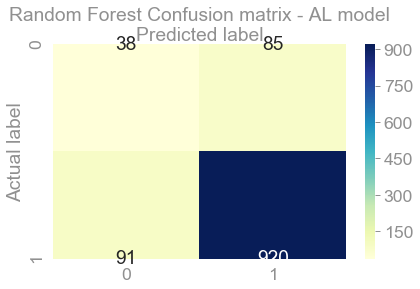

In [37]:
# PRINT OUT A PRETTY CONFUSION MATRIX
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix - AL model', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig("Model2_confusionmatrix2.pdf", bbox_inches='tight')
plt.show()